Synthetic dataset generated. Rows: 20000
Default rate: 0.03065

ML Simulation Results
ROC AUC: 0.5000
PR AUC: 0.0317
Accuracy: 0.9692
Confusion matrix:
[[3877    0]
 [ 123    0]]
CV ROC AUC mean: 0.4901, std: 0.0177

Top features:
          feature  importance
6  trend_balance    0.113752
9    trend_spend    0.109322
3     volatility    0.103386
5    std_balance    0.103051
8      std_spend    0.102901


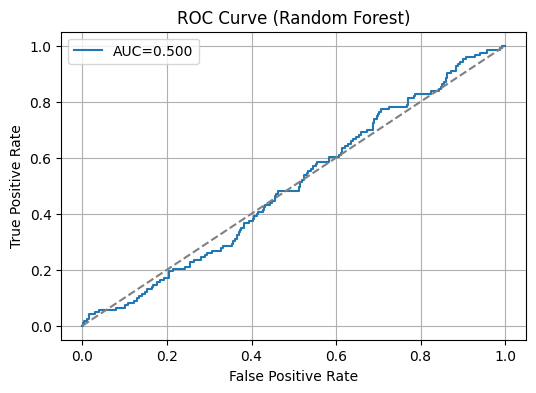

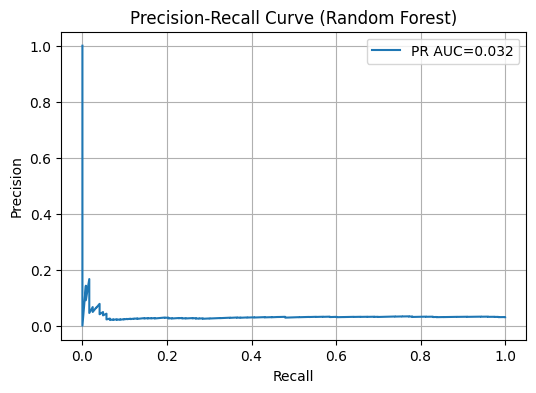

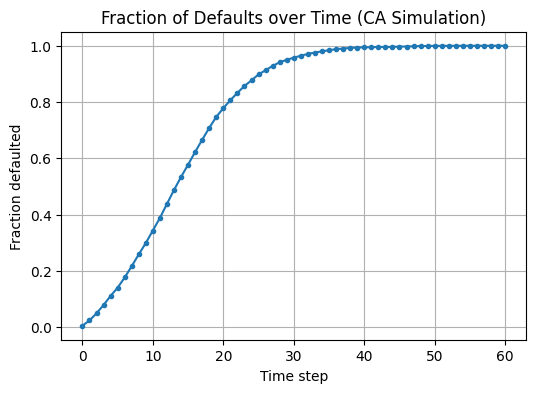

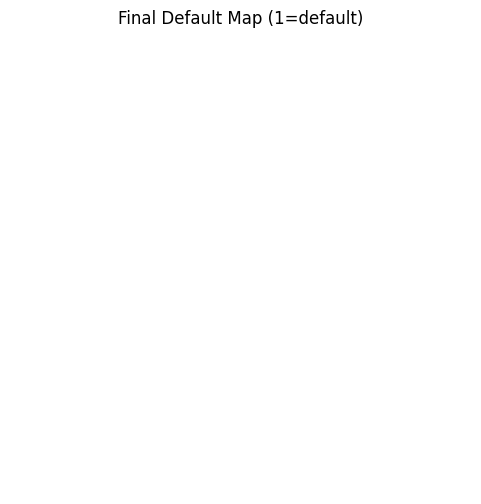


Outputs saved to folder 'simulation_outputs'


In [5]:
# Workshop 4 simulations for SmartRisk (synthetic dataset - Option B)
# Requirements: numpy, pandas, scikit-learn, matplotlib
# Run in a Kaggle Notebook or local Jupyter environment

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, accuracy_score, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

np.random.seed(42)
os.makedirs("simulation_outputs", exist_ok=True)

# -----------------------------
# Part A: Synthetic Data Generation (advanced)
# -----------------------------
n_customers = 20000
n_months = 12

customer_ids = [f"C{str(i).zfill(6)}" for i in range(n_customers)]
rows = []
for cid in customer_ids:
    base_income = np.random.lognormal(mean=10, sigma=0.5)

    # gastos promedio siempre positivos
    avg_spend = abs(np.random.normal(loc=0.3*base_income, scale=0.1*base_income))

    credit_util = np.clip(np.random.beta(a=2, b=5), 0.01, 0.99)
    volatility = np.random.uniform(0.1, 0.6)

    # Balances mensuales (escala siempre positiva)
    balance_scale = max(volatility * base_income, 1)
    monthly_balances = np.abs(np.random.normal(
        loc=base_income*0.05,
        scale=balance_scale,
        size=n_months
    ))

    # Gastos mensuales (escala siempre positiva)
    spend_scale = max(volatility * avg_spend / 12, 1)
    monthly_spends = np.abs(np.random.normal(
        loc=avg_spend/12,
        scale=spend_scale,
        size=n_months
    ))

    mean_balance = monthly_balances.mean()
    std_balance = monthly_balances.std()
    trend_balance = np.polyfit(np.arange(n_months), monthly_balances, 1)[0]

    mean_spend = monthly_spends.mean()
    std_spend = monthly_spends.std()
    trend_spend = np.polyfit(np.arange(n_months), monthly_spends, 1)[0]

    risk_score = (1 / (1 + np.exp(-( -0.00001*base_income + 2*credit_util - 0.001*trend_balance + volatility ))))
    default_prob = 0.03 * (1 + (risk_score - risk_score.mean()))
    default = np.random.rand() < np.clip(default_prob, 0.001, 0.5)

    rows.append({
        "customer_ID": cid,
        "base_income": base_income,
        "avg_spend": avg_spend,
        "credit_util": credit_util,
        "volatility": volatility,
        "mean_balance": mean_balance,
        "std_balance": std_balance,
        "trend_balance": trend_balance,
        "mean_spend": mean_spend,
        "std_spend": std_spend,
        "trend_spend": trend_spend,
        "default": int(default)
    })


df = pd.DataFrame(rows)
df.to_csv("simulation_outputs/synthetic_customers.csv", index=False)
print("Synthetic dataset generated. Rows:", len(df))
print("Default rate:", df['default'].mean())

# -----------------------------
# Part B: Data-driven Simulation (RandomForest baseline)
# -----------------------------
features = ["base_income","avg_spend","credit_util","volatility","mean_balance","std_balance","trend_balance","mean_spend","std_spend","trend_spend"]
X = df[features].values
y = df['default'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42, n_jobs=-1)
rf.fit(X_train_s, y_train)

y_prob = rf.predict_proba(X_test_s)[:,1]
y_pred = rf.predict(X_test_s)

roc_auc = roc_auc_score(y_test, y_prob)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

print("\nML Simulation Results")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")
print(f"Accuracy: {acc:.4f}")
print("Confusion matrix:")
print(cm)

# Cross-validated ROC AUC
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf, scaler.transform(X), y, scoring='roc_auc', cv=cv, n_jobs=-1)
print(f"CV ROC AUC mean: {cv_scores.mean():.4f}, std: {cv_scores.std():.4f}")

# Feature importances
fi = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending=False)
fi.to_csv("simulation_outputs/feature_importances.csv", index=False)
print("\nTop features:\n", fi.head())

# Save predictions
pred_df = pd.DataFrame({
    "customer_ID": df.iloc[len(df)-len(y_test):].customer_ID.values,
    "y_true": y_test, "y_prob": y_prob, "y_pred": y_pred
})
pred_df.to_csv("simulation_outputs/ml_predictions.csv", index=False)

# Plots: ROC and PR
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],"--", color="gray")
plt.title("ROC Curve (Random Forest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend()
plt.savefig("simulation_outputs/roc_curve.png")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f"PR AUC={pr_auc:.3f}")
plt.title("Precision-Recall Curve (Random Forest)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid(True)
plt.legend()
plt.savefig("simulation_outputs/pr_curve.png")
plt.show()

# -----------------------------
# Part C: Event-based Simulation (Cellular Automaton)
# -----------------------------
grid_size = 60
steps = 60
E = 0.02
neighbor_influence_weight = 0.2

np.random.seed(42)
grid = np.zeros((grid_size, grid_size), dtype=int)
initial_seed = np.random.choice([0,1], size=(grid_size, grid_size), p=[0.995, 0.005])
grid += initial_seed

def step_ca(grid, E, neighbor_weight):
    new = grid.copy()
    rows, cols = grid.shape
    for i in range(rows):
        for j in range(cols):
            if grid[i,j] == 1:
                continue
            i0 = max(0,i-1); i1 = min(rows-1,i+1)
            j0 = max(0,j-1); j1 = min(cols-1,j+1)
            neigh = grid[i0:i1+1, j0:j1+1]
            neigh_frac = neigh.sum() / neigh.size
            p_default = E + neighbor_weight * neigh_frac
            if np.random.rand() < p_default:
                new[i,j] = 1
    return new

fractions = []
grid_t = grid.copy()
fractions.append(grid_t.mean())
grids_over_time = [grid_t.copy()]
for t in range(steps):
    grid_t = step_ca(grid_t, E, neighbor_influence_weight)
    grids_over_time.append(grid_t.copy())
    fractions.append(grid_t.mean())

ca_df = pd.DataFrame({"time": range(len(fractions)), "fraction_defaulted": fractions})
ca_df.to_csv("simulation_outputs/ca_summary.csv", index=False)

plt.figure(figsize=(6,4))
plt.plot(fractions, marker='o', markersize=3)
plt.title("Fraction of Defaults over Time (CA Simulation)")
plt.xlabel("Time step")
plt.ylabel("Fraction defaulted")
plt.grid(True)
plt.savefig("simulation_outputs/ca_fraction.png")
plt.show()

plt.figure(figsize=(6,6))
plt.imshow(grids_over_time[-1], interpolation='nearest', cmap='Greys')
plt.title("Final Default Map (1=default)")
plt.axis('off')
plt.savefig("simulation_outputs/ca_final_map.png")
plt.show()

print("\nOutputs saved to folder 'simulation_outputs'")
